<font color="#1e90ff"><h1><b>Notebook 1</b></h1></font>

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

print("TensorFlow version: {}".format(tf.__version__))

# Load data
def load_cifar10():
  (X_train_cifar, y_train_cifar), (X_test_cifar, y_test_cifar) = cifar10.load_data()
  y_train_cifar = y_train_cifar.squeeze()
  y_test_cifar = y_test_cifar.squeeze()
  return (X_train_cifar, y_train_cifar), (X_test_cifar, y_test_cifar)

# CIFAR100 classes
idx_to_class = ['background', 'car', 'truck']

# Construct vehicle dataset from CIFAR10
def construct_vehicle_dataset(data, labels, images_per_class, label_car=1, label_truck=9):
  mask_car = labels == label_car
  mask_truck = labels == label_truck

  mask_vehicles = mask_car | mask_truck
  mask_background = np.invert(mask_vehicles)

  data_car = data[mask_car]
  data_truck = data[mask_truck]
  data_background = data[mask_background][:images_per_class]

  new_data = np.vstack((data_background, data_car, data_truck))
  new_labels = np.repeat(np.array([0, 1, 2]), images_per_class, axis=0)

  return new_data, new_labels

def load_vehicle_dataset():
  (X_train_cifar, y_train_cifar), (X_test_cifar, y_test_cifar) = load_cifar10()
  X_train, y_train = construct_vehicle_dataset(X_train_cifar, y_train_cifar, 5000)
  X_test, y_test = construct_vehicle_dataset(X_test_cifar, y_test_cifar, 1000)
  return (X_train, y_train), (X_test, y_test)

# Helper functions

# plotting
def plot_one_image(data, labels = [], index = None, image_shape = None):
  '''
  if data is a single image, display that image

  if data is a 4d stack of images, display that image
  '''
  ### cv2.imshow('image', data)
  num_dims   = len(data.shape)
  num_labels = len(labels)
  if image_shape is not None:
    target_shape = image_shape
  else:
    target_shape = (32, 32, 3)
  # reshape data if necessary
  if num_dims == 1:
    data = data.reshape(target_shape)
  if num_dims == 2:
    data = data.reshape(np.vstack[-1, image_shape])
  num_dims   = len(data.shape)

  # check if single or multiple images
  if num_dims == 3:
    if num_labels > 1:
      print('Multiple labels does not make sense for single image.')
      return

    label = labels
    if num_labels == 0:
      label = ''
    image = data

  if num_dims == 4:
    if index is not None:
      image = data[index, :]
      label = labels[index]

    else:
      print("Images were provided as a list, but the index variable was left blank")

  # plot image of interest
  print('Label: %s'%label)
  plt.imshow(image)
  plt.show()

def model_to_string(model):
  import re
  stringlist = []
  model.summary(print_fn=lambda x: stringlist.append(x))
  sms = "\n".join(stringlist)
  sms = re.sub('_\d\d\d','', sms)
  sms = re.sub('_\d\d','', sms)
  sms = re.sub('_\d','', sms)
  return sms

def normalize(data):
  # CIFAR100 mean (0.4914, 0.4822, 0.4465) std (0.2023, 0.1994, 0.2010)
  return (data/255-np.array((0.4914, 0.4822, 0.4465))) / np.array((0.2023, 0.1994, 0.2010))

def label_to_onehot(labels):
  final_labels = np.zeros((len(labels), 3))
  for i in range(len(labels)):
    label = labels[i]
    if label == 0:
      final_labels[i,:] = np.array([1, 0, 0])
    if label == 1:
      final_labels[i,:] = np.array([0, 1, 0])
    if label == 2:
      final_labels[i,:] = np.array([0, 0, 1])
  return final_labels

def plot_acc(history, ax = None, xlabel = 'Epoch #'):
  # i'm sorry for this function's code. i am so sorry.
  history = history.history
  history.update({'epoch':list(range(len(history['val_accuracy'])))})
  history = pd.DataFrame.from_dict(history)

  best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

  if not ax:
    f, ax = plt.subplots(1,1)
  sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
  sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
  ax.axhline(0.333, linestyle = '--',color='red', label = 'Chance')
  ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
  ax.legend(loc = 1)
  ax.set_ylim([0.01, 1])

  ax.set_xlabel(xlabel)
  ax.set_ylabel('Accuracy (Fraction)')

  plt.show()



TensorFlow version: 2.17.0


# Understanding our data

In [2]:
(X_train, y_train), (X_test, y_test) = load_vehicle_dataset()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [3]:
print('Our labels are stored as %s in Python' % type(y_train))
print('The label vector of the training set has dimensions of (%d, )' % y_train.shape)
print('The label vector of the test set has dimensions of (%d, )' % y_test.shape)

Our labels are stored as <class 'numpy.ndarray'> in Python
The label vector of the training set has dimensions of (15000, )
The label vector of the test set has dimensions of (3000, )


In [4]:
for i, class_name in enumerate(idx_to_class):
  print('{} - {}'.format(i, class_name))


0 - background
1 - car
2 - truck


In [5]:

import collections

### YOUR CODE HERE
counter_train = collections.Counter(y_train)
print(counter_train)
counter_test = collections.Counter(y_test)
print(counter_test)
### END CODE

Counter({0: 5000, 1: 5000, 2: 5000})
Counter({0: 1000, 1: 1000, 2: 1000})


Next, let's take a look at the images in the dataset.

In [6]:
print(X_train.shape)
print(X_test.shape)


(15000, 32, 32, 3)
(3000, 32, 32, 3)


Label: ['truck']


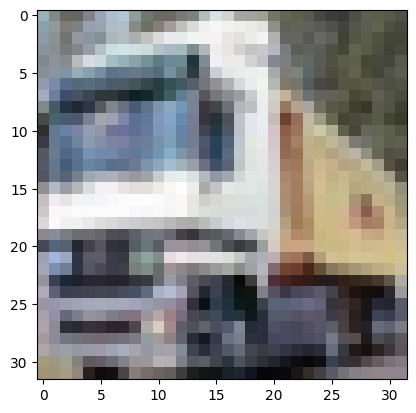

In [8]:

# 0-4999 Background, 5000-9999 car, 10000-15000 truck

image = X_train[10000]
label = [idx_to_class[y_train[10000]]]
plot_one_image(image, labels=label)


# Understanding and Building Neural Networks (Perceptron)

In [14]:
# grab tools from our tensorflow and keras toolboxes
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import optimizers

In [13]:

model_1 = Sequential()
model_1.add(Dense(4, input_shape = (3,), activation = 'relu'))
model_1.add(Dense(2, activation = 'softmax'))
model_1.compile(loss='categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])


# Applying Neural Networks to Recognizing Vehicles


In [16]:

### YOUR CODE HERE
perceptron = Sequential()
perceptron.add(Flatten(input_shape = (32, 32, 3)))
perceptron.add(Dense(units = 128, activation = 'relu'))
perceptron.add(Dense(units = 3, activation = 'softmax'))

perceptron.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.SGD(learning_rate=1e-3, momentum=0.9),
                   metrics=['accuracy'])
### END CODE

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [22]:

monitor = ModelCheckpoint('./model.h5.keras', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

y_train_onehot = label_to_onehot(y_train)
y_test_onehot = label_to_onehot(y_test)

history = perceptron.fit(X_train_norm, y_train_onehot, epochs=20, validation_data=(X_test_norm, y_test_onehot), shuffle=True, callbacks=[monitor])


Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5827 - loss: 1.0427 - val_accuracy: 0.6627 - val_loss: 0.7577
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7190 - loss: 0.6815 - val_accuracy: 0.6840 - val_loss: 0.7656
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7545 - loss: 0.6143 - val_accuracy: 0.7127 - val_loss: 0.6926
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7850 - loss: 0.5474 - val_accuracy: 0.7127 - val_loss: 0.6819
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7993 - loss: 0.5099 - val_accuracy: 0.7310 - val_loss: 0.6689
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8190 - loss: 0.4700 - val_accuracy: 0.7073 - val_loss: 0.7003
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8298 - loss: 0.4389 - val_accuracy: 0.7180 - val_loss: 0.7030
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8485 - loss: 0.4060 - val_accuracy: 0.

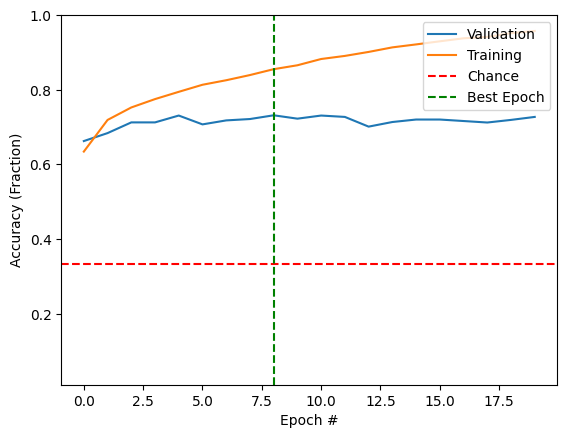

In [23]:
#@title Instructor Solution { display-mode: "form" }
plot_acc(history)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
0.7273333333333334
Plotting the Confusion Matrix


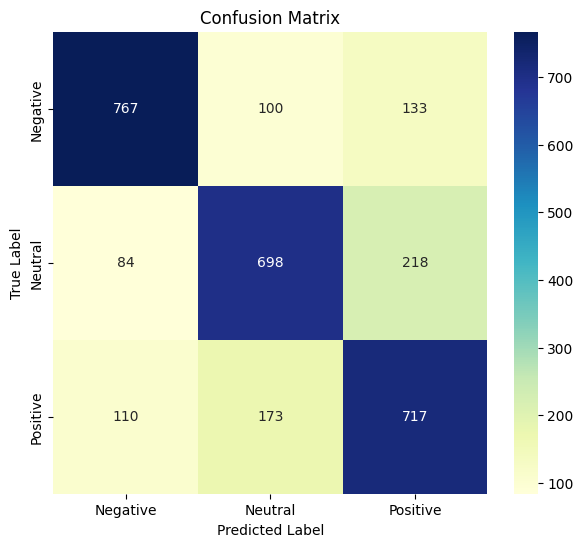

In [24]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  print("Plotting the Confusion Matrix")

  labels = ["Negative","Neutral","Positive"]
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  fig = plt.figure(figsize=(7,6))
  res = sns.heatmap(df_cm, annot=True, cmap='YlGnBu', fmt='g')

  plt.yticks([0.5,1.5,2.5], labels, va='center')
  plt.title('Confusion Matrix')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()
  plt.close()

pred_probs = perceptron.predict(X_test_norm)
y_pred = pred_probs.argmax(axis = -1)
y_true = y_test_onehot.argmax(axis = -1)

print(accuracy_score(y_true, y_pred))
plot_confusion_matrix(y_true, y_pred)

# Notebook Summary

The notebook's model overfit, we can fix it and improve it in model 2.